In [1]:
repo_url = 'https://github.com/6165-MSET-CuttleFish/TeamTrack'

In [2]:
from utils.gitutils import clone_repo

# Clone the repo
repo = clone_repo(repo_url)
local_repo_path = str(repo.working_dir)

In [3]:
from utils.filetreeutils import FileTree

(file_tree := FileTree.from_dir(local_repo_path))

├── .git\
│   ├── hooks\
│   │   ├── applypatch-msg.sample
│   │   ├── commit-msg.sample
│   │   ├── fsmonitor-watchman.sample
│   │   ├── post-update.sample
│   │   ├── pre-applypatch.sample
│   │   ├── pre-commit.sample
│   │   ├── pre-push.sample
│   │   ├── pre-rebase.sample
│   │   ├── pre-receive.sample
│   │   ├── prepare-commit-msg.sample
│   │   ├── update.sample
│   ├── info\
│   │   ├── exclude
│   ├── logs\
│   │   ├── refs\
│   │   │   ├── heads\
│   │   │   │   ├── master
│   │   │   ├── remotes\
│   │   │   │   ├── origin\
│   │   │   │   │   ├── HEAD
│   │   ├── HEAD
│   ├── objects\
│   │   ├── info\
│   │   ├── pack\
│   │   │   ├── pack-24978a03ff0c9be525cfb85f73b1e2850ffd215c.idx
│   │   │   ├── pack-24978a03ff0c9be525cfb85f73b1e2850ffd215c.pack
│   ├── refs\
│   │   ├── heads\
│   │   │   ├── master
│   │   ├── remotes\
│   │   │   ├── origin\
│   │   │   │   ├── HEAD
│   │   ├── tags\
│   ├── config
│   ├── description
│   ├── HEAD
│   ├── index
│   ├── packed-ref

In [6]:
from utils.agent import Agent, GenerationConfig
from dotenv import load_dotenv
from utils.frameworkutils import Framework
import os

load_dotenv()

API_KEY = os.getenv('API_KEY')

frameworks = ', '.join(Framework.get_frameworks())

classifier = Agent(
    model_name="gemini-1.5-flash-001",
    api_key=API_KEY,
    name="classifier",
    generation_config=GenerationConfig(temperature=0.3),
    system_prompt=f"""You are a software engineer tasked with classifying the framework of a codebase into one of the  following frameworks:
{frameworks}.
-----------------------------------
In the following prompts, you will be given the subdirectories of a codebase. Directory names can be misleading. You can respond with one of the following:
- IDENTIFY: FRAMEWORK_NAME (Only select this if you are absolutely certain that the ROOT directory conforms) (it should be used sparingly)
- N/A (if you cannot identify the framework based on the subdirectories)
- END (if you are fairly certain that no frameworks are in the subdirectories)"""
)

In [7]:
import re
from utils.agent import Interaction
from utils.languageutils import get_imports
import networkx as nx
from utils.listutils import flatten, compact
# RegEx to match classifier responses
identify_re = re.compile(r"IDENTIFY: (.+)")
end_re = re.compile(r"END")
unable_re = re.compile(r"N/A")

def classify_node(node):
    node_dict = file_tree.nodes[node]
    neighbors = list(file_tree[node])
    prompt = f"{file_tree.nodes[node]['name']}\n" + f"{file_tree.subfiletree(node).copy(withDepth=1)}"
    context = [Interaction(f'Relevant content of {neighbor}\n----\n' + '\n'.join(imports), '...') for  neighbor in  neighbors if 'content' in file_tree.nodes[neighbor] and (imports := get_imports(file_tree.nodes[neighbor]['path']))]
    response = classifier.chat(prompt, custom_context=context)
    # Match the response to the RegEx
    if (m := identify_re.match(response)):
        framework  = m.group(1).strip()
        print(f"{node_dict['name']} is a {framework} project")
        file_tree.nodes[node]['framework'] = framework
        for node in nx.dfs_tree(file_tree, node).nodes:
            file_tree.nodes[node]['frameworks'] = [framework]
        return [framework]
    elif (m := unable_re.match(response)):
        print(f"Searching {node} ...")
        frameworks = compact(flatten([classify_node(node) for node in neighbors if 'content' not in file_tree.nodes[node]]))
        file_tree.nodes[node]['frameworks'] = frameworks
    elif (m := end_re.match(response)):
        print(f"{node_dict['name']} is not a framework")
        return None
    else:
        print(f"Classifier response: {response}")
        return None

(root_classification := classify_node(file_tree.root_node()))

. is a FLUTTER project


['FLUTTER']

# Visualize File Tree

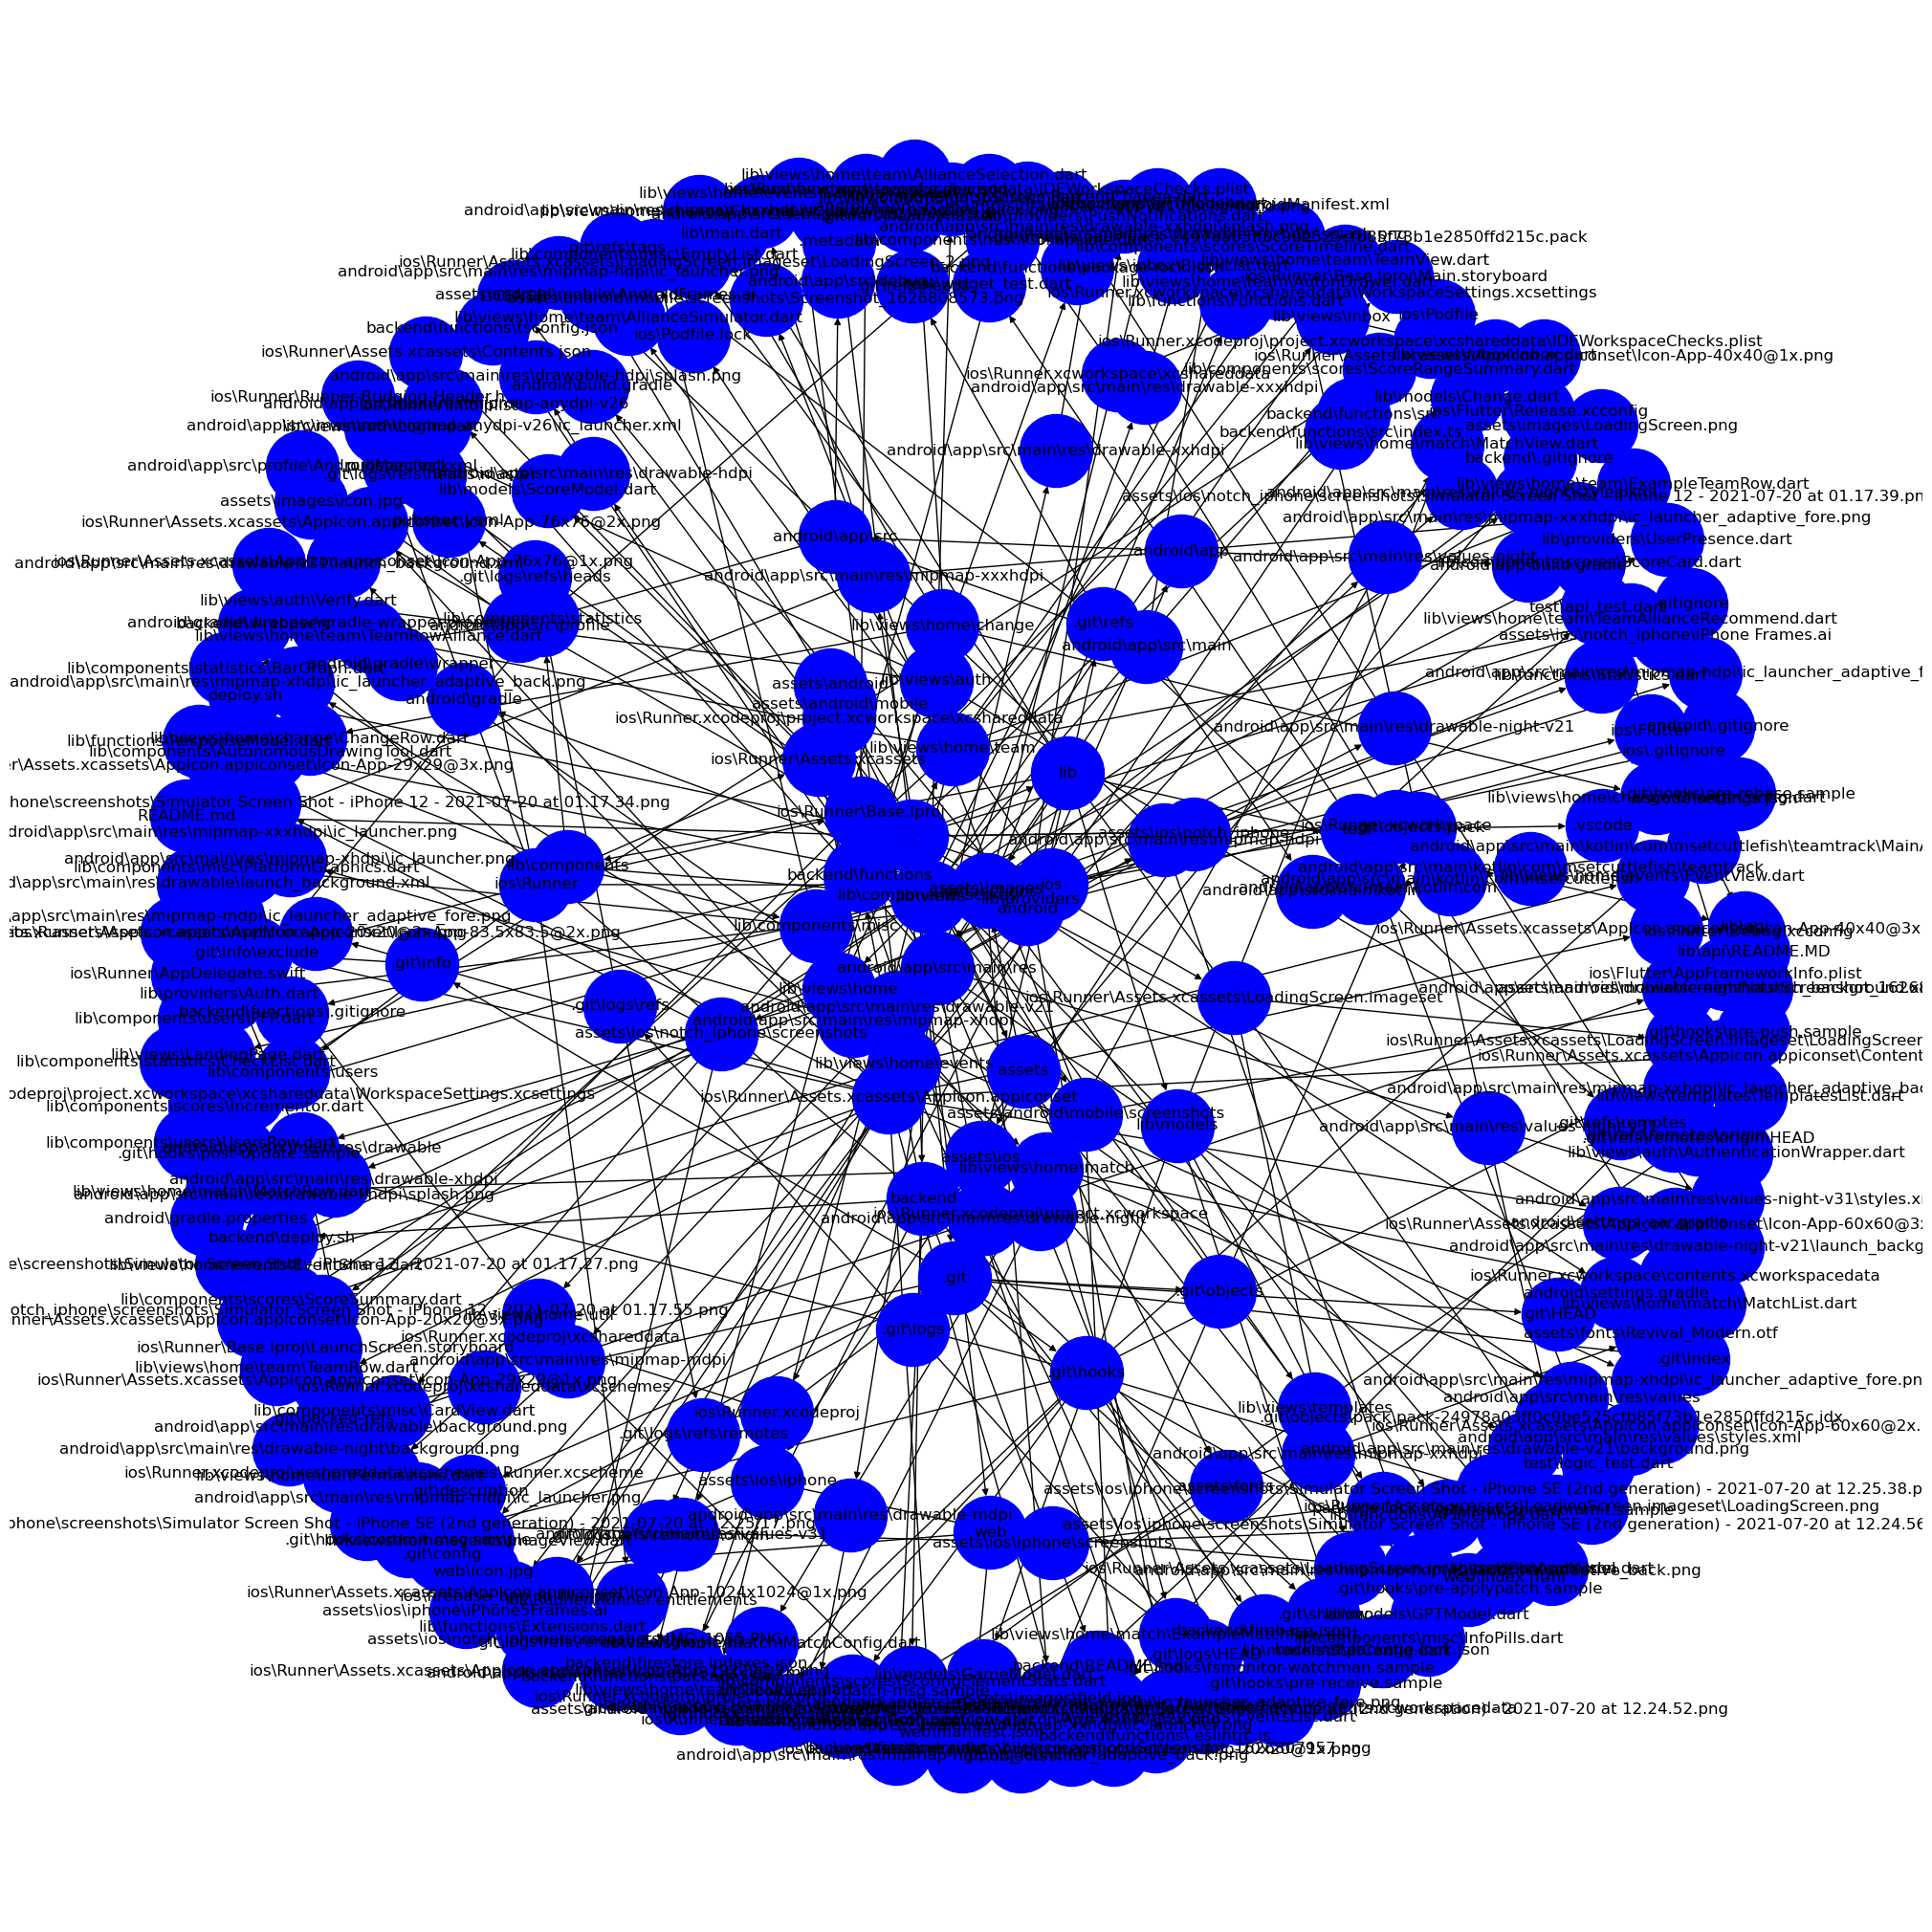

In [10]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

def get_color(framework):
    match framework:
        case 'FLUTTER':
            return 'blue'
        case 'REACT':
            return 'green'
        case _:
            return 'red'

# Draw the tree
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(file_tree, seed=0)
nx.draw(file_tree, pos, with_labels=True, node_size=3000, node_color=[get_color(framework) for framework in nx.get_node_attributes(file_tree, 'framework').values()])
plt.show()